In [1]:
import numpy as np
import torch
my_matrix = np.loadtxt(open("results.csv"),delimiter=",",skiprows=0)
#print(my_matrix)
 #对于矩阵而言，将矩阵倒数第一列之前的数值给了X（输入数据），将矩阵大最后一列的数值给了y（标签）
X, y = my_matrix[:,:-1],my_matrix[:,-1]
X = np.load('encoded_data.npy')

#X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y,dtype = torch.long), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((1139, 8)), 1, y_, 1)



In [2]:
import pennylane.templates as em
#import pennylane.operation as operation
import pennylane as qml
import pennylane as qml

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    em.AngleEmbedding(inputs, wires=range(n_qubits))
    em.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [3]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
clayer_1 = torch.nn.Linear(3, 3)
clayer_2 = torch.nn.Linear(3, 8)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

In [7]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(3, 4)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(6, 8)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 2, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

In [8]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss = torch.nn.L1Loss()

In [9]:
import torch.utils.data as Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.3, random_state=1)

X_train = torch.tensor(X_train, requires_grad=True).float()
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test, requires_grad=True).float()
y_test = torch.tensor(y_test)
y_test = torch.argmax(y_test, dim=1).detach().numpy()

batch_size = 5
batches = 200 // batch_size


data_loader = Data.DataLoader(
    list(zip(X_train, y_train)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 20
epoch_list =[]
train_loss =[]
acc_test = []

for epoch in range(epochs):
    epoch_list.append(epoch)
    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()
        
        out = model(xs)
        loss_evaluated = loss(out, ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    train_loss.append(avg_loss)
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

    y_pred = model(X_test)
    predictions = torch.argmax(y_pred, dim=1).detach().numpy()
    
    correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y_test)]
    accuracy = sum(correct) / len(correct)
    acc_test.append(accuracy)
    print(f"Accuracy: {accuracy * 100}%")

/home/contree/anaconda3/envs/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/contree/anaconda3/envs/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Average loss over epoch 1: 0.7671
Accuracy: 50.29239766081871%
Average loss over epoch 2: 0.5148
Accuracy: 56.14035087719298%
Average loss over epoch 3: 0.3931
Accuracy: 67.2514619883041%
Average loss over epoch 4: 0.3349
Accuracy: 78.94736842105263%
Average loss over epoch 5: 0.2885
Accuracy: 74.85380116959064%
Average loss over epoch 6: 0.2720
Accuracy: 78.94736842105263%
Average loss over epoch 7: 0.2469
Accuracy: 76.90058479532163%
Average loss over epoch 8: 0.2404
Accuracy: 81.57894736842105%
Average loss over epoch 9: 0.2308
Accuracy: 80.99415204678363%
Average loss over epoch 10: 0.2230
Accuracy: 80.7017543859649%
Average loss over epoch 11: 0.2219
Accuracy: 80.11695906432749%
Average loss over epoch 12: 0.2134
Accuracy: 82.45614035087719%
Average loss over epoch 13: 0.2064
Accuracy: 82.45614035087719%
Average loss over epoch 14: 0.2048
Accuracy: 82.45614035087719%
Average loss over epoch 15: 0.1989
Accuracy: 82.7485380116959%
Average loss over epoch 16: 0.1943
Accuracy: 83.3333

In [10]:
guess = torch.argmax(y_pred, dim=1).detach().numpy()
fact = y_test

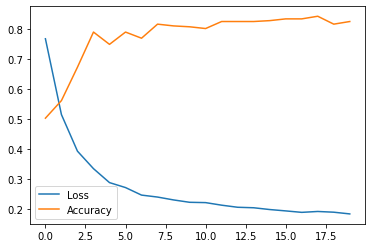

In [29]:
import matplotlib.pyplot as plt

plt.plot(epoch_list,train_loss, label = 'Loss')
plt.plot(epoch_list,acc_test, label = 'Accuracy')
plt.legend()
plt.savefig('QNN_Loss.tif', dpi = 400)
plt.show()
#np.save('Loss_CNN.npy',Loss_CNN)

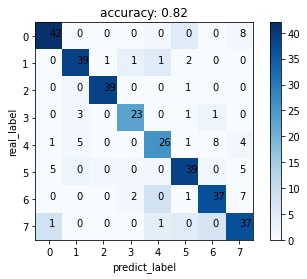

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
#print(accuracy_score(fact,guess),recall_score(fact, guess,average='macro'))

# 类别
classes = list(set(fact))
# 排序，准确对上分类结果
classes.sort()
# 对比，得到混淆矩阵
confusion = confusion_matrix(guess, fact)
# 热度图，后面是指定的颜色块，gray也可以，gray_x反色也可以
plt.imshow(confusion, cmap=plt.cm.Blues)
# 这个东西就要注意了
# ticks 这个是坐标轴上的坐标点
# label 这个是坐标轴的注释说明
indices = range(len(confusion))
# 坐标位置放入
# 第一个是迭代对象，表示坐标的顺序
# 第二个是坐标显示的数值的数组，第一个表示的其实就是坐标显示数字数组的index，但是记住必须是迭代对象
plt.xticks(indices, classes)
plt.yticks(indices, classes)
# 热度显示仪？就是旁边的那个验孕棒啦
plt.colorbar()
# 就是坐标轴含义说明了
plt.xlabel('predict_label')
plt.ylabel('real_label')
# 显示数据，直观些
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
plt.title('accuracy: 0.82')
plt.savefig('QNN_results.tif', dpi = 400)
plt.show()